<center>
<font color="orange">
<h2 style="font-family: 'Times New Roman', sans-serif;">A content-based restaurant recommendation system tailored to individual preferences </h2>
</font>
</center>
<center>
<font color="orange">
<h4 style="font-family: 'Times New Roman', sans-serif;"> by Njeri Mwenjwa</h4>
</font>
</center>


# Table of Contents
**1. Introduction**<br>
**2. Data Collection**<br>
**3. Data Processing**<br>
**4. Calculate Similarity Scores**<br>
**5. Recommendations**<br>
**6. Performance**<br>
**7. Executive Summary**<br>



## Introduction
My friends and I are always busy - we have school, work study, personal projects and so much more going on in our lives that getting the time and mental freedom to hang out has been difficult. But humans must eat, and so we have structured our bonding times around meals. We go out to get dinner every opportunity we have, usually on the weekends. Because we are college students, we have to get our money’s worth. So we (usually me) spend lots of time looking through the internet for good restaurants that will hopefully satisfy the craving of the day. To improve this painful process of scouring google maps reviews for flavourful food, I have decided to create a recommendation system.

Specifically, a content-based recommendation system for restaurants based in Buenos Aires. A content-based recommendation system is a type of recommendation system that suggests items to users based on the characteristics or features of the items, and the user’s past behaviour and preferences. This system recommends items that are similar in content to what the user has shown interest in or interacted with before.

I chose a content-based recommendation system because this is my second semester in Buenos Aires. Therefore I have already built a user profile of Buenos Aires restaurants I interacted with last Fall. Some features of the restaurants I have included are 'cuisine', 'number of reviews', ‘price range’ and 'average rating'. These are the factors I personally account for when picking a restaurant. Thus the recommendation system will rely on this information on the restaurants to generate predictions that a user (me) will likely find useful. More on the algorithmic process will come soon.


In [2711]:
import pandas as pd
import math
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
# pip install wordcloud
from wordcloud import WordCloud
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr


## Data Collection<br>
I created a dataset of most of the restaurants I went to last Fall and this Fall. I did this by looking through my Photos gallery and using the location data to find the names of the restaurants. From there, I gave a rating on a scale of 1 - 5 based on my recollection of the experience I had. I’m not one to forget a positive or negative dining experience so my reviews are fairly accurate. My user profile data initially included the amount of money I spent in each restaurant as well. However, given the level of inflation Argentina is experiencing, the money spent is no longer an accurate representation of how much one would spend today, therefore I left that out and opted to use Google Maps price ranges instead. I also used Google Maps to fill in the gaps for certain categories necessary for my user profile like ‘cuisine’ and 'descriptions'.

In this dataset, I also included about 150 other restaurants in Buenos Aires. I did this using the Google Maps API, so I queried it for the categories previously mentioned ('cuisine', 'number of reviews', ‘price range’, ‘average rating’ and 'descriptions'). This is the pool of restaurants the model will use to recommend restaurants to me.


In [2712]:
# Define your API key and the search query
api_key = 'MY API KEY'
query = 'restaurants in Buenos Aires'

# Define the API endpoint URL
url = 'https://maps.googleapis.com/maps/api/place/textsearch/json'

# Parameters for the request
params = {
    'query': query,
    'key': api_key
}

# Send the GET request
response = requests.get(url, params=params)

In [2713]:
PATH = 'ba_resto.csv'

# import data
df = pd.read_csv(PATH)

df_copy = df.copy()
df.head()

,name,cuisine,rating,no_of_reviews,price_range,user_id,description,place_id,about
0,Elena,South American,4.6,2323.0,4,0,offers dine-in service only and is closed betw...,1.0,"{""Service options"": {""Dine-in"": true, ""Deliver..."
1,Tomo 1,Fine dining,4.6,450.0,4,0,a fine dining restaurant located within the Bu...,2.0,"{""Service options"": {""Outdoor seating"": true, ..."
2,Cabernet,Argentinian,4.2,2486.0,3,0,Intimate fine dining spot offering European fa...,3.0,"{""Service options"": {""Outdoor seating"": true, ..."
3,ALMA BuenosAires,Argentinian,4.5,230.0,0,0,offers dine-in and takeaway service options bu...,4.0,"{""Service options"": {""Outdoor seating"": true, ..."
4,Santos Manjares,Steak house,4.7,4092.0,2,0,"a highly-rated steakhouse in BuenosAires, loca...",5.0,"{""From the business"": {""Identifies as women-ow..."


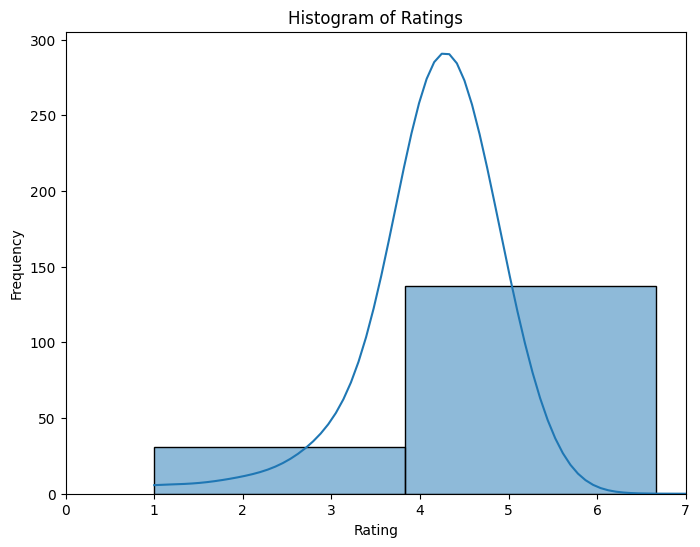

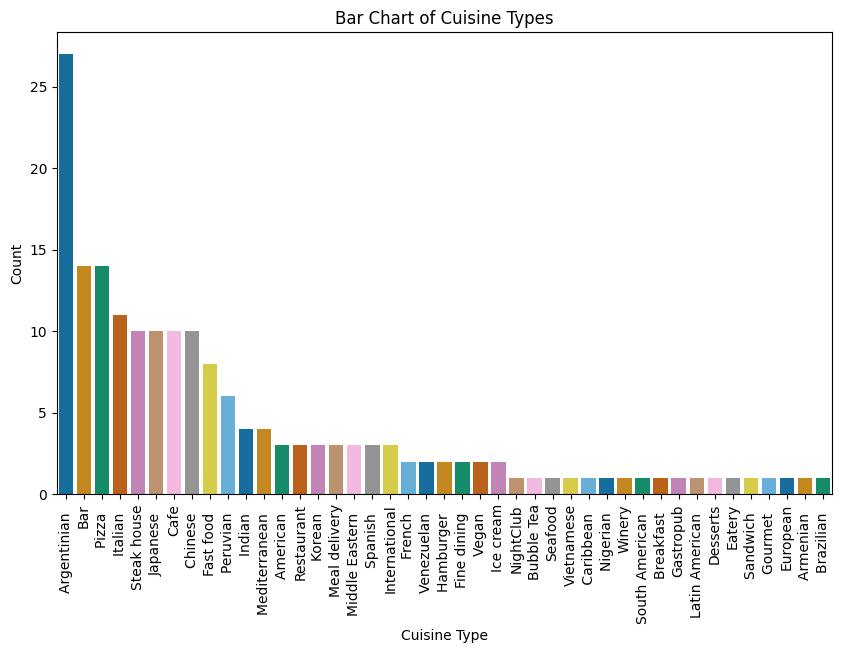

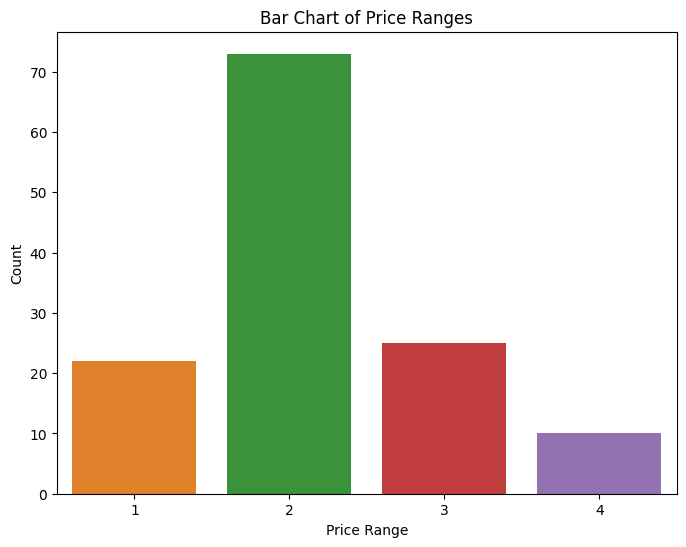

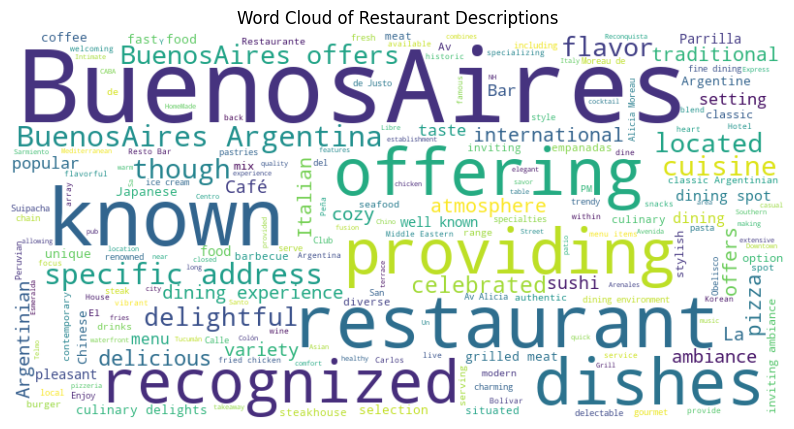

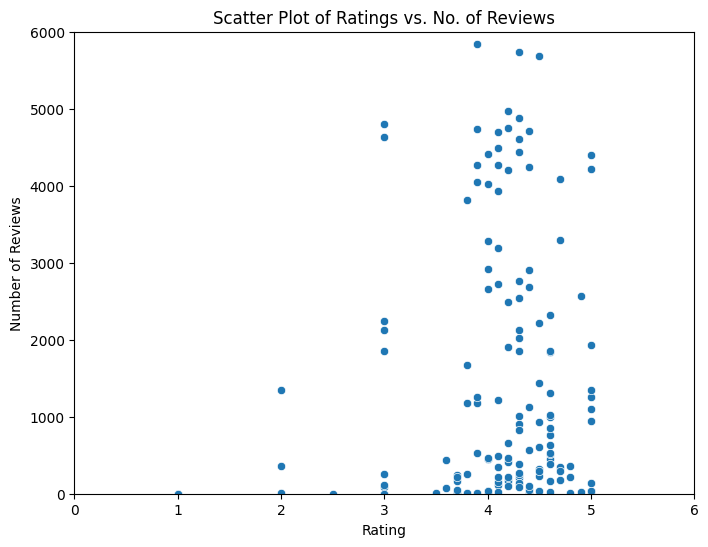

In [2714]:
# 1. Histogram of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=6, kde=True, edgecolor='black')
plt.xlim(0,7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()


# 2. Bar Chart of Cuisine Types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cuisine', 
            order=df['cuisine'].value_counts().index, palette="colorblind")
plt.xlabel('Cuisine Type')
plt.ylabel('Count')
plt.title('Bar Chart of Cuisine Types')
plt.xticks(rotation=90)
plt.show()

# 3. Bar Chart of Price Ranges
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='price_range')
plt.xlim(0.5,4.5)
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Bar Chart of Price Ranges')
plt.show()

# 4. Word Cloud of Restaurant Descriptions
text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, 
                    background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Restaurant Descriptions')
plt.show()

# 5. Scatter Plot of Ratings vs. No. of Reviews
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='rating', y='no_of_reviews')
plt.xlim(0,6)
plt.ylim(0,6000)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Scatter Plot of Ratings vs. No. of Reviews')
plt.show()


These are some trends and observations that can be made based on the provided data. 

**Cuisine Types:**
1. Argentinian cuisine appears to be quite popular, with a significant number of restaurants offering this type of cuisine.
2. Italian, Steakhouse, and Japanese cuisines also have a notable presence in the dataset.
3. Some less common cuisines like Venezuelan, Brazilian, Armenian, and Mediterranean are represented by only a few restaurants.

**Ratings:**
1. The dataset includes a wide range of ratings, which is typical for a diverse set of restaurants. 
2.  Most restaurants have high ratings, with 4.0 and above being common. There are some restaurants with a perfect 5.0 rating.
3. Few restaurants have low ratings, with a minimum of 1.0, suggesting there might be some underperforming establishments.

**Number of Reviews:**
1. Some restaurants have a substantial number of reviews, indicating they are well-known and frequently visited.
2. However, there are also restaurants with very few or even no reviews. This suggests variations in popularity and possibly new entries in the dataset.

**Price Ranges:**
1. Price ranges vary from 0 (possibly representing low-cost or budget options) to 4 (indicating higher-priced or fine dining establishments).
2. Many restaurants fall in the middle price ranges (2 and 3).

**Missing Values:**
1. There are missing values in the 'description' column for some restaurants.
2. Some restaurants have missing values in other columns, including 'rating' and 'price_range'.

**Price Range and Ratings:**
1. Price range doesn't always correlate directly with ratings, as there are restaurants with both high and low ratings across different price ranges.

## Data Preprocessing <br>
‘Price range’ is ordinal and categorical:
- $: This is a low-priced restaurant. <br>
- \$$: This restaurant is moderately priced. <br>
- 4 stars: Expect high prices for this restaurant. <br>

I initially mapped the price tags to a numerical range (1- 4). This is suitable as there is a natural order among the categories.

I normalised the numeric columns ‘rating’ and ‘number of reviews’ to fit within a range 0-1. This ensures that they are on the same scale, preventing ‘number of reviews’ from dominating ‘rating’ as a factor determining recommendation.

In [2715]:
def normalize(data):
    '''
    Normalize a list of values to be between 0 and 1.
    
    Parameters:
        data (List) : The list of values you want to normalize
    
    Returns:
        The input data normalized between 0 and 1
    
    Source: (Vatsal, 2021)
    '''
    # Find the minimum value in the data
    min_value = min(data)

    # If the minimum value is negative, shift all values to make them 
    # positive
    if min_value < 0:
        data = [x + abs(min_value) for x in data]
    
    # Find the maximum value in the data
    max_value = max(data)

    # Normalize the data to be between 0 and 1
    return [x / max_value for x in data]


# Normalize the 'rating' and number of reviews columns
df['rating_normalized'] = normalize(df['rating']
                                        .values)
df['no_of_reviews_normalized'] = normalize(df['no_of_reviews']
                                                .values)

I also carried out text summarisation on the 'description' column using TF-IDF.

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical technique used to convert text data, in our case - restaurant descriptions, into numerical representations. It works by evaluating the importance of words within each description relative to their frequency in the entire dataset. The TF-IDF score assigns higher values to words that are unique and meaningful within a description while downgrading common words. By calculating the average TF-IDF score for each description, we can create a single numerical value that represents the description's content, which is useful for integrating this textual data into a dataframe with other entries.

This is the process:
- I carried out tokenisation, which is separating the sentences into words, making it easier to analyze the text at a granular level.
- Now, we calculate the TF-IDF values for each word in the description. TF-IDF considers two factors:
    1. Term Frequency (TF): This measures how frequently a term (word) appears in a specific description. It's calculated as the number of times a term occurs in a description divided by the total number of terms in that description.
    2. Inverse Document Frequency (IDF): This assesses the importance of a term within the entire dataset. It's calculated as the logarithm of the total number of descriptions divided by the number of descriptions containing the term.
The TF-IDF score for a term in a description is then TF multiplied by IDF.

- Averaging TF-IDF: After calculating TF-IDF scores for all terms in a description, I took the the average TF-IDF score for that description. This average TF-IDF score condenses the textual content into a single numerical value that quantifies the importance of the description's content. Terms that are unique to a specific description or are highly informative receive higher scores, while common terms get lower scores.

In [2716]:
def text_summarisation(df):
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the restaurant descriptions
    tfidf_matrix = vectorizer.fit_transform(df['description'])

    # Calculate the average TF-IDF score for each restaurant 
    # description
    average_tfidf_scores = tfidf_matrix.mean(axis=1)

    # Add the average TF-IDF scores to the DataFrame
    return average_tfidf_scores

# Now, our DataFrame 'df' contains a column 'description_score' 
# with numerical values representing the restaurant descriptions.
df['description_score']  = text_summarisation(df)

I then carried out One-Hot Encoding (OHE) on the ‘cuisine’ column. OHE creates binary columns for each category, where each column represents the presence or absence of that category. I used this method because ‘cuisine’ is a categorical column, thus OHE ensures no false order is introduced.



In [2717]:
def one_hot_encode_and_append(df, column_name):
    '''
    This function performs one-hot encoding 
    on a specified column and appends it back to the dataframe.
    
    One-hot encodes the specified categorical column 
    and appends it to the input dataframe.

    One-hot encoding transforms categorical variables 
    into numerical format before
    fitting and training machine learning models.

    Parameters:
        df (DataFrame): The dataframe to which 
        the one-hot encoded columns will be appended.

        column_name (String): The name of the 
        column to be one-hot encoded.

    Returns:
        The dataframe with the one-hot encoded columns appended.
    '''

    # Perform one-hot encoding on the specified column
    one_hot_encoded_df = pd.get_dummies(df[column_name],dtype='int64')

    # Reset the index of the one-hot encoded DataFrame
    one_hot_encoded_df.reset_index(drop=True, inplace=True)

    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    return pd.concat([df, one_hot_encoded_df], axis=1)


# One-hot encode 'type', 'price range'
df = one_hot_encode_and_append(df, column_name='cuisine')
df.head()

,name,cuisine,rating,no_of_reviews,price_range,user_id,description,place_id,about,rating_normalized,...,Restaurant,Sandwich,Seafood,South American,Spanish,Steak house,Vegan,Venezuelan,Vietnamese,Winery
0,Elena,South American,4.6,2323.0,4,0,offers dine-in service only and is closed betw...,1.0,"{""Service options"": {""Dine-in"": true, ""Deliver...",0.255556,...,0,0,0,1,0,0,0,0,0,0
1,Tomo 1,Fine dining,4.6,450.0,4,0,a fine dining restaurant located within the Bu...,2.0,"{""Service options"": {""Outdoor seating"": true, ...",0.255556,...,0,0,0,0,0,0,0,0,0,0
2,Cabernet,Argentinian,4.2,2486.0,3,0,Intimate fine dining spot offering European fa...,3.0,"{""Service options"": {""Outdoor seating"": true, ...",0.233333,...,0,0,0,0,0,0,0,0,0,0
3,ALMA BuenosAires,Argentinian,4.5,230.0,0,0,offers dine-in and takeaway service options bu...,4.0,"{""Service options"": {""Outdoor seating"": true, ...",0.250000,...,0,0,0,0,0,0,0,0,0,0
4,Santos Manjares,Steak house,4.7,4092.0,2,0,"a highly-rated steakhouse in BuenosAires, loca...",5.0,"{""From the business"": {""Identifies as women-ow...",0.261111,...,0,0,0,0,0,1,0,0,0,0


I then dropped the now irrelevant features like the pre-normalised rating and number of reviews columns; and the pre-OHE cuisine columns. 


In [2718]:
# drop redundant columns
cols = [
'name','cuisine','rating','no_of_reviews','about',
'description','place_id'
    ]
df.drop(columns = cols, inplace = True)

This is a representation of the dataframe we will be working with.

In [2719]:
df.head()

,price_range,user_id,rating_normalized,no_of_reviews_normalized,description_score,Caribbean,American,Argentinian,Armenian,Bar,...,Restaurant,Sandwich,Seafood,South American,Spanish,Steak house,Vegan,Venezuelan,Vietnamese,Winery
0,4,0,0.255556,0.025241,0.004315,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,4,0,0.255556,0.004890,0.003830,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.233333,0.027012,0.005226,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.250000,0.002499,0.007957,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0.261111,0.044462,0.004526,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Calculate Similarity Scores <br>
As mentioned above, Content-based recommendation systems suggest items to users based on their past behaviour and preferences. The system  recommends items that are similar in content to what the user has shown interest in or interacted with before. To figure out how similar a user’s preferences are to each restaurant in the dataset, we use a mathematical method called cosine of similarity. 
Cosine of similarity is a measure of similarity between two non-zero vectors projected in a multi-dimensional space. Every cosine of similarity value lies within the range [-1,1], where two completely opposite vectors have a similarity score of -1, and completely similar vectors have a similarity score of 1. Two vectors with a similarity score of 0 are orthogonal to each other, indicating a lack of correlation. Intermediate similarity scores indicate an intermediate level of similarity. In some instances, the component values of the vectors cannot be negative, in which case, the cosine of similarity is bounded in [0,1] and the previous logic prevails. Two different vectors have a similarity score near 0, and two similar vectors have a similarity score close to 1.(Javed, 2020),(Wikipedia Contributors, 2019)


In the restaurant recommender, the cosine of similarity is calculated between each restaurant I have reviewed and all the other restaurants in the dataset. Each restaurant in our dataset is systematically transformed into a vector in a multi-dimensional space, with various features defining its position along these dimensions. These features are cuisine type, price range, number of reviews and ratings. Thus each restaurant will have a similarity score with every other restaurant in the dataset.

The formula used to calculate the cosine of similarity is the following:

$$
\text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}
$$
Where:
- $ \mathbf{A} \text{ and } \mathbf{B} $ are restaurant vectors to be compared.
- $ \cdot $ represents the dot product of the two vectors.
- $ \mathbf{A} \text{ and } \mathbf{B}$ are the Euclidean norms (magnitude) of the vectors $ \mathbf{A} \text{ and } \mathbf{B} $, respectively.

This formula calculates the cosine of the angle between two vectors, providing a measure of similarity that ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating no similarity.  This mathematical approach ensures that our recommendations are firmly rooted in user preferences, providing personalized and mathematically accurate suggestions.

To begin, we filter the main dataframe to create a 'user_profile' dataframe made up only of restaurants I have reviewed.
Now we have two dataframes:
1. Original dataframe 'df' made up of ALL restaurants in the dataset.
2. User Profile dataframe 'user_profile' made up of ONLY restaurants I have reviewed.

In [2720]:
# Filter the DataFrame based on the desired user_id
user_profile = df.loc[df['user_id'] == 1]

We then fill any missing values with a 0 on both dataframes to remove any Null values that may make it difficult for sklearn to calculate cosine of similarity.

In [2721]:
# Fill missing values with 0

# user_profile dataframe
user_profile = user_profile.fillna(0)

# original comprehensive dataframe
df = df.fillna(0)

Using sklearn's inbuilt 'cosine_similarity' function, we pass in the user_profile and original dataframes to get the cosine of similarity scores for all restaurants in the dataset.

In [2722]:
# Calculate cosine similarity between user's preferences 
# and restaurant data
similarity_scores = cosine_similarity(user_profile, df)
print(similarity_scores)

[[0.79291275 0.79282221 0.7756885  ... 0.8620054  0.70822038 0.86207403]
 [0.5623567  0.5623662  0.5511432  ... 0.69608726 0.67206714 0.69761409]
 [0.79259962 0.79258428 0.77504724 ... 0.86192116 0.70639278 0.86184433]
 ...
 [0.87782251 0.87776344 0.85840416 ... 1.         0.69608657 0.90916444]
 [0.56235664 0.56236651 0.55114259 ... 0.69608657 1.         0.69761373]
 [0.87800542 0.878021   0.85876387 ... 0.90916444 0.69761373 1.        ]]


In [2723]:
# Create a DataFrame to store similarity scores for each restaurant
similarity_df = pd.DataFrame(similarity_scores, columns=df.index)

In [2724]:
# Transpose the DataFrame for easy sorting and ranking
# so each column is a restaurant on person_1's profile 
# and we get how similar it is to each restaurant in the dataset
similarity_df = similarity_df.transpose()
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.792913,0.562357,0.792600,0.792959,0.792983,0.792368,0.792747,0.792540,0.792910,0.561773,...,0.792491,0.878015,0.792273,0.561800,0.792498,0.562389,0.792765,0.877823,0.562357,0.878005
1,0.792822,0.562366,0.792584,0.792915,0.792949,0.792240,0.792608,0.792534,0.792828,0.561782,...,0.792410,0.878023,0.792120,0.561777,0.792421,0.562395,0.792631,0.877763,0.562367,0.878021
2,0.775688,0.551143,0.775047,0.776005,0.904170,0.775764,0.775847,0.775870,0.904170,0.550981,...,0.775860,0.858776,0.775684,0.551025,0.775865,0.550762,0.775862,0.858404,0.551143,0.858764
3,0.016528,0.030887,0.011020,0.021957,0.411615,0.027402,0.021993,0.027355,0.416322,0.038425,...,0.027378,0.016227,0.027407,0.038438,0.027385,0.023246,0.021990,0.012219,0.030882,0.016233
4,0.731681,0.523404,0.729842,0.732920,0.731586,0.733940,0.732998,0.733752,0.732984,0.524711,...,0.733920,0.809407,0.733923,0.524830,0.733916,0.521578,0.733001,0.808438,0.523403,0.809379


The result is a dataframe of the cosine of similarity score between the restaurants already in my user profile (the columns) and all the restaurants in the dataset (the rows).

For example, the first reviewed restaurant (column 0) and the first restaurant in the dataset (row 0) have a similarity score of $0.085209$. The second reviewed restaurant (row 1) and the first restaurant in the dataset (row 0) have a similarity score of $0.107225$

One thing to note is that all similarity scores are positive.
As previously mentioned, if all your entries are positive, it means that the cosine similarity values are being calculated based on non-negative vectors. In such cases, cosine similarity is bounded between 0 and 1, not -1 and 1. All numerical entries in our dataset (price range, ratings, number of reviews) are positive. <br>
Therefore:
- Cosine similarity between 0 and 1 indicates similarity, with 1 indicating perfect similarity. This means that the vectors are more aligned in the same direction.
- Cosine similarity of 0 indicates no similarity.



## Recommendations <br>
The next step is to take as input a restaurant that I like and store in the 'choice_index' variable.<br>
Below is a table of all restaurants I have interacted with. I simply need to choose the restaurant index, store this index in the choice_index and the model will recommend a variety of similar restaurants.

| Restaurant Name                       | Cuisine                 | Restaurant Index |
|--------------------------------------|-------------------------|---------|
| Restaurant Montaneses                | Spanish restaurant      | 1      |
| Dickson Resto/Bar                    | Nigerian restaurant     | 2      |
| Chipper Seafood Restaurant            | Caribbean restaurant    | 3      |
| Emperarodo Meiji                      | Japanese restaurant     | 4      |
| No Tan Santos Nuñez                  | Argentinian restaurant  | 5       |
| La Pescadorita                       | Seafood                 | 6      |
| Café San Bernardo                    | Bar                     | 7      |
| Harakiri de Una                      | Japanese restaurant     | 8      |
| Sur Restaurant                        | Argentinian restaurant  | 9       |
| Otoshi Sushi & Poke                  | Japanese restaurant     | 10      |
| Glück Cervecería - zona Olavarría    | Bar                     | 11     |
| Fa Song Song                         | Korean restaurant       | 12      |
| Kika Club                            | NightClub               | 13      |
| La Posada de 1820                   | Argentinian restaurant  | 14     |
| Costa Tigre Maxikiosco               | Cafe                    | 15      |
| Tanta Argentina by Gastón Acurio    | Peruvian restaurant     | 16      |
| Touchdown                            | Pizza restaurant        | 17      |
| Sushi Lives                          | Japanese restaurant     | 18      |
| Dragon Chinese Food                  | Chinese restaurant      | 19      |
| Intanto Bar                          | Chinese restaurant      | 20      |
| Ribs al Río                         | American restaurant     | 21     |
| Dostana                             | Indian restaurant       | 22      |
| Oh! Tea                             | Bubble Tea              | 23      |
| Harina Pizzas y Empanadas           | Pizza restaurant        | 24      |
| Hoshi                               | Japanese restaurant     | 25      |
| Delhi Mahal                         | Indian restaurant       | 26      |
| Gran Dabbang                        | Indian restaurant       | 27      |
| Suship Arenales                     | Japanese restaurant     | 28      |
| Saigón Noodle Bar                   | Vietnamese              | 29      |
| Snailey Walker                      | Bar                     | 30      |
| Rapanui                            | Ice cream               | 31     |
| Nicolo                             | Ice cream               | 32      |
| Bilbo Café                         | Cafe                    | 33      |
| DeliWok                            | Chinese restaurant      | 34      |
| Broccolino                        | Italian restaurant       | 35      |
| Trattoria Olivetti                | Italian restaurant       | 36      |
| La Conga                         | Peruvian restaurant     | 37    |


The similarity dataframe below stores the similarity scores between all the restaurants in the dataset, thus it models different relationships. Therefore we need to sort the dataframe depending on the restaurant for which we want to generate a list of similar restaurants. Thus we sort by 'choice_index'.

In [2725]:
def choose_restaurant(choice_index, similarity_df):
    """
    Choose a restaurant as the basis for generating recommendations.

    Parameters:
    choice_index (int): The index of the restaurant to
      base recommendations on.
      
    similarity_df (pd.DataFrame): A DataFrame containing similarity 
      scores between restaurants and user preferences.

    Returns:
    pd.DataFrame: A sorted DataFrame with restaurants ranked by their 
      similarity to the chosen restaurant.

    This function takes a restaurant index and a similarity DataFrame 
      as input and sorts the restaurants in the DataFrame by their 
      similarity score to the chosen restaurant. The result is a 
      DataFrame where restaurants are ranked by their similarity to 
      the chosen restaurant, with the most similar restaurants at the 
      top.

    Example:
    >>> recommendations = choose_restaurant(5, similarity_df)
    """
    # Sort restaurants by similarity score for this user
    similarity_df = similarity_df.sort_values(by=choice_index, 
                                              ascending=False)
    similarity_df


Next, we assume that wanting to eat food from a particular restaurant signals a craving for a particular cuisine. Thus we extract the specific cuisine of the chosen restaurant.

In [2726]:
def determine_cuisine(choice_index):
    """
    Determine the cuisine type based on a chosen restaurant.

    Parameters:
    choice_index (int): The index of the restaurant used to 
        determine the cuisine.

    Returns:
    str: The cuisine type of the chosen restaurant.

    This function calculates the cuisine type based on 
        a chosen restaurant's index.
    It adjusts the index and extracts the cuisine type 
        from the DataFrame. The cuisine
    type is then printed as a craving and returned.

    Example:
    >>> cuisine = determine_cuisine(5)
    >>> print(f"I'm craving {cuisine}")
    I'm craving Italian
    """
    # Adjust the choice index
    choice_index = 142 + choice_index - 2

    # Get the cuisine type of the chosen restaurant
    cuisine_type = df_copy.iloc[choice_index]['cuisine']

    # Print the craving and return the cuisine type
    print(f"I'm craving {cuisine_type}")
    print('\n')
    return cuisine_type


To avoid choice overload, which is an instance where one gets overwhelmed when presented with a large number of options to choose from, we can pre-define the total number of recommendations one would like to receive. This way, I can define the number of options I'm comfortable with and save my mental energy for my dining experience.

For this model, I am implementing the 'recommendation' aspect in two ways:
The main step is to generate a list of the most similar restaurants to the chosen restaurant -- 'top restaurants'
1. Half the number of recommendations will be of restaurants of a similar cuisine as the choice restaurant, in order of their similarity score.
2. The remaining half will be the restaurants with the highest similarity score but of a DIFFERENT cuisine. For some spontaneity.
ALL the recommendations will be of restaurants I have NEVER interacted with or given a review on.

In [2727]:
def cuisine_recommendations(cuisine_type, total_no_of_recommendations, 
                            recommended_list):
    """
    Generate restaurant recommendations based on cuisine similarity.

    This function takes a cuisine type, 
        the total number of recommendations desired, 
        and a list of recommended restaurants.
    It finds restaurants of the specified cuisine in 
        the most similar restaurant list.

    Args:
    - cuisine_type (str): The target cuisine type.
    - total_no_of_recommendations (int): Total 
        number of recommendations needed.
    - recommended_list (list): A list to store 
        the recommended restaurant indices.

    Returns:
    - recommended_list (list): A list of recommended restaurant indices.
    - count (int): The number of recommendations found.
    """
    # Calculate the number of recommendations for the same cuisine
    similar_cuisine_recs = math.ceil(total_no_of_recommendations / 2) 

    # Get the index of the top similar restaurants
    top_restaurants = similarity_df.index
    count = 0

    # Iterate through the top restaurants and check their cuisine
    for restaurant_index in top_restaurants:

        # Access the cuisine of the restaurant from 
        # the original DataFrame
        cuisine = df.iloc[restaurant_index] 

        # Check if the restaurant has the specific cuisine 
        # (assuming the cuisine column is a boolean)
        # Check the restaurant hasn't been reviewed by user
        # indices less than 141 haven't been reviewed by user
        if cuisine[cuisine_type] == 1 and restaurant_index < 141:
            recommended_list.append(restaurant_index)
            count += 1

            # Break the loop if we have reached the desired 
            # number of similar cuisine recommendations
            if count >= similar_cuisine_recs:
                break

    return recommended_list, count


In [2728]:
def diverse_recommendations(cuisine_type, total_no_of_recommendations, 
                            recommended_list, count):
    """
    Generate diverse restaurant recommendations.

    This function takes a cuisine type, 
        the total number of recommendations desired, 
        a list of recommended restaurants, and a count.
    It finds restaurants of different cuisines that 
        haven't been reviewed by the user from the most
        similar restaurant list.

    Args:
    - cuisine_type (str): The target cuisine type.
    - total_no_of_recommendations (int): 
        Total number of recommendations needed.
    - recommended_list (list): 
        A list to store the recommended restaurant indices.
    - count (int): The number of recommendations found so far.

    Returns:
    - recommended_list (list): A list of recommended restaurant indices.
    """
    # Get the index of the top similar restaurants
    diverse_recs = similarity_df.index 

    # Iterate through the top restaurants and check their cuisine
    for restaurant_index in diverse_recs:
        # Access the cuisine of the restaurant from 
        # the original DataFrame
        cuisine = df.iloc[restaurant_index]

        # Check if the restaurant has a different cuisine 
        # (assuming the cuisine column is a boolean)
        # Check the restaurant hasn't been reviewed by the user 
        # (indices less than 141 haven't been reviewed)
        if cuisine[cuisine_type] != 1 and restaurant_index < 141:
            recommended_list.append(restaurant_index)
            count += 1

            # Break the loop if we have reached the desired number of 
            # diverse recommendations
            if count >= total_no_of_recommendations:
                break

    return recommended_list


| Restaurant Name                       | Cuisine                 | Restaurant Index |
|--------------------------------------|-------------------------|---------|
| Restaurant Montaneses                | Spanish restaurant      | 1      |
| Dickson Resto/Bar                    | Nigerian restaurant     | 2      |
| Chipper Seafood Restaurant            | Caribbean restaurant    | 3      |
| Emperarodo Meiji                      | Japanese restaurant     | 4      |
| No Tan Santos Nuñez                  | Argentinian restaurant  | 5       |
| La Pescadorita                       | Seafood                 | 6      |
| Café San Bernardo                    | Bar                     | 7      |
| Harakiri de Una                      | Japanese restaurant     | 8      |
| Sur Restaurant                        | Argentinian restaurant  | 9       |
| Otoshi Sushi & Poke                  | Japanese restaurant     | 10      |
| Glück Cervecería - zona Olavarría    | Bar                     | 11     |
| Fa Song Song                         | Korean restaurant       | 12      |
| Kika Club                            | NightClub               | 13      |
| La Posada de 1820                   | Argentinian restaurant  | 14     |
| Costa Tigre Maxikiosco               | Cafe                    | 15      |
| Tanta Argentina by Gastón Acurio    | Peruvian restaurant     | 16      |
| Touchdown                            | Pizza restaurant        | 17      |
| Sushi Lives                          | Japanese restaurant     | 18      |
| Dragon Chinese Food                  | Chinese restaurant      | 19      |
| Intanto Bar                          | Chinese restaurant      | 20      |
| Ribs al Río                         | American restaurant     | 21     |
| Dostana                             | Indian restaurant       | 22      |
| Oh! Tea                             | Bubble Tea              | 23      |
| Harina Pizzas y Empanadas           | Pizza restaurant        | 24      |
| Hoshi                               | Japanese restaurant     | 25      |
| Delhi Mahal                         | Indian restaurant       | 26      |
| Gran Dabbang                        | Indian restaurant       | 27      |
| Suship Arenales                     | Japanese restaurant     | 28      |
| Saigón Noodle Bar                   | Vietnamese              | 29      |
| Snailey Walker                      | Bar                     | 30      |
| Rapanui                            | Ice cream               | 31     |
| Nicolo                             | Ice cream               | 32      |
| Bilbo Café                         | Cafe                    | 33      |
| DeliWok                            | Chinese restaurant      | 34      |
| Broccolino                        | Italian restaurant       | 35      |
| Trattoria Olivetti                | Italian restaurant       | 36      |
| La Conga                         | Peruvian restaurant     | 37    |


In [2729]:
def get_recommendations(choice_index, total_no_of_recommendations):
    """
    Get restaurant recommendations based on choice and cuisine.

    This function takes a choice index and the total number of 
        recommendations desired. 
        It selects a restaurant, determines its cuisine, 
        and then generates a list of recommendations 
        based on that cuisine and diversity criteria.

    Args:
    - choice_index (int): The index of the chosen restaurant.
    
    - total_no_of_recommendations (int): Total number of 
        recommendations needed.

    Returns:
    None
    """
    # Choose a restaurant and sort the dataframe
    choose_restaurant(choice_index, similarity_df)

    # Determine the cuisine type of the chosen restaurant
    cuisine_type = determine_cuisine(choice_index)

    # initialise list to append indices of recommended restaurants
    recommended_list = []
    recommended_list, count = cuisine_recommendations(cuisine_type,
                total_no_of_recommendations, recommended_list)
    recommended_list = diverse_recommendations(cuisine_type, 
                total_no_of_recommendations, recommended_list, count)

    # Iterate through the recommended list 
    # and print details of each restaurant
    for r in range(len(recommended_list)):
        restaurant = df_copy.iloc[recommended_list[r]]
        print(f'Recommendation {r+1}:')
        print(f'Name: {restaurant["name"]}')
        print(f'Cuisine: {restaurant["cuisine"]}')
        print(f'Price Range: {restaurant["price_range"]}')
        print(f'Rating: {restaurant["rating"]}')
        print(f'Number of Reviews: {restaurant["no_of_reviews"]}')
        print(f'Description: {restaurant["description"]}\n')


In [2730]:
choice_index = 37
total_no_of_recommendations = 8
get_recommendations(choice_index,total_no_of_recommendations)

I'm craving Peruvian  


Recommendation 1:
Name: Coya
Cuisine: Peruvian  
Price Range: 2
Rating: 3.9
Number of Reviews: 526.0
Description:  Av. Alicia Moreau de Justo 134, BuenosAires
 BuenosAires, Argentina
 Coya is a fine dining restaurant with a focus on Peruvian cuisine, known for its fusion of flavors and stunning riverside location.

Recommendation 2:
Name: Restaurante Rawa
Cuisine: Peruvian  
Price Range: 2
Rating: 4.1
Number of Reviews: 1216.0
Description: Av. Cerviño 4602, BuenosAires, Argentina - A contemporary restaurant with a focus on seafood and international cuisine, offering a fresh and modern dining experience.

Recommendation 3:
Name: Bar Roman
Cuisine: Peruvian  
Price Range: 1
Rating: 4.1
Number of Reviews: 341.0
Description: Bar Roman, though not providing a specific address, is known for its inviting ambiance and culinary delights.

Recommendation 4:
Name: Jarana
Cuisine: Peruvian  
Price Range: 3
Rating: 4.6
Number of Reviews: 631.0
Description: Jarana, a recogni

Here's the entire recommendation process described in pseudocode:

1. **Create User Profile**: To start, we begin by filtering the main restaurant dataset to create a new DataFrame called 'user_profile.' This DataFrame contains only the restaurants that one has reviewed.
   ```
   user_profile = FilterMainDatasetToUserReviewedRestaurants()
   ```

2. **Fill Missing Values**: It's important to ensure that there are no missing values in the data to prevent any issues when calculating similarity scores. We fill any missing values in both the main dataset ('df') and the 'user_profile' with zeros.
   ```
   user_profile.FillMissingValues()
   df.FillMissingValues()
   ```

3. **Calculate Cosine Similarity Scores**: We proceed to calculate the cosine similarity scores between the 'user_profile' and all the restaurants in the main dataset using the 'cosine_similarity' function provided by the sklearn library. This results in a matrix of similarity scores.
   ```
   similarity_scores = CalculateCosineSimilarity(user_profile, df)
   ```

4. **Store Similarity Scores**: We create a new DataFrame, 'similarity_df,' to store these similarity scores, where each row represents a restaurant from the main dataset and each column corresponds to a restaurant in one's 'user_profile.'
   ```
   similarity_df = CreateSimilarityDataFrame(similarity_scores)
   ```

5. **Choose a Restaurant**: You select a restaurant of your choice by specifying its index as 'choice_index.' This restaurant will serve as the reference point for generating recommendations.
   ```
   choice_index = UserSelectsRestaurant()
   ```

6. **Sort Similarity Scores**: We sort the 'similarity_df' based on the similarity scores of your chosen restaurant ('choice_index'). This will help identify the most similar restaurants.
   ```
   sorted_similarity_df = SortSimilarityScoresByChoiceRestaurant(choice_index)
   ```

7. **Determine the Chosen Restaurant's Cuisine**: We extract the cuisine of the chosen restaurant. This is done to provide cuisine-specific recommendations.
   ```
   chosen_cuisine = DetermineCuisine(choice_index)
   ```

8. **Set the Total Number of Recommendations**: You can specify the total number of restaurant recommendations you want to receive.
   ```
   total_recommendations = UserSpecifiesTotalRecommendations()
   ```

9. **Generate Recommendations**:
   We generate recommendations in two ways:
      - Half of the recommendations will be restaurants of the same cuisine as the chosen restaurant. These restaurants are sorted by their similarity scores.
      - The remaining half of the recommendations will be restaurants of different cuisines with the highest similarity scores, adding a touch of spontaneity to the recommendations.
      ```
      similar_cuisine_recommendations, diverse_recommendations = GenerateRecommendations(
      sorted_similarity_df, chosen_cuisine, total_recommendations)
      ```

10. **Combine Recommendations** : Finally, we combine both sets of recommendations to form a list of top restaurant suggestions based on your chosen restaurant and your preferences.
      ```
      combined_recommendations = CombineRecommendations(
      similar_cuisine_recommendations, diverse_recommendations)
      ```

11. **Display Recommendations**: The code concludes by displaying the generated restaurant recommendations, which you can use to make dining choices.
      ```
      DisplayRecommendations(combined_recommendations)
      ```

## Performance


To measure the performance of our Restaurant Recommender, the ideal mechanism is using Spearman's Rank Correlation Coefficient.

**Spearman's Rank Correlation Coefficient**<br>
Spearman's rank correlation coefficient is a statistical metric used to measure the performance of a content-based recommendation system. (Wikipedia Contributors, 2019b)It assesses the relationship between two ranked datasets and provides insights into how well the system's recommendations align with a user's actual preferences. In this context, the first ranked dataset consists of the model's recommendations 'ranked_model_recommendations'. These are the model's predictions of ratings I could have given to the original set of restaurants in my user profile, ranked by similarity score. The second dataset is made up of my own ratings of restaurants in my user profile, ranked by rating. This is to create a target & predictions scenario since we can only determine a model's accuracy by analysing how well it matches my preferences.

The coefficient, denoted as ρ (rho), falls within a range of -1 to 1, where -1 indicates a perfect inverse correlation (the model's recommendations are the complete opposite of the user's preferences), 0 suggests no correlation (the recommendations do not match the user's preferences), and 1 signifies a perfect positive correlation (the recommendations precisely match the user's preferences). Intermediate values indicate varying levels of agreement between the system's suggestions and the user's preferences.

By calculating Spearman's rank correlation coefficient, the restaurant recommendation system can quantitatively assess its performance. A high positive correlation indicates that the system is effectively recommending items in line with the user's preferences, while a negative or low correlation suggests room for improvement. Additionally, the accompanying p-value helps determine the statistical significance of the correlation coefficient, allowing us to make informed decisions regarding the reliability of our recommendation system's accuracy.

The formula for Spearman's Rank Correlation Coefficient.

$$
\rho = 1 - \frac{6\sum{d_i^2}}{n(n^2 - 1)}
$$

Where:

- $\rho$ represents Spearman's rank correlation coefficient.
- $d_i$ signifies the differences in ranks between corresponding data points in the two datasets.
- $ n $ denotes the number of data points in the datasets being compared.

In [2731]:
# Squeeze and sort the 'user_profile' DataFrame by the 'rating_normalized' column in descending order
# This will sort the user's preferences in descending order, with the most preferred restaurants at the top
target_preferences = user_profile.squeeze().sort_values(by='rating_normalized', ascending=False)

# Display the sorted 'target_preferences' DataFrame
target_preferences.head()

,price_range,user_id,rating_normalized,no_of_reviews_normalized,description_score,Caribbean,American,Argentinian,Armenian,Bar,...,Restaurant,Sandwich,Seafood,South American,Spanish,Steak house,Vegan,Venezuelan,Vietnamese,Winery
160,1,1,1.000000,0.017863,0.005501,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,1,1,0.277778,0.001532,0.005032,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,2,1,0.277778,0.014582,0.005049,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,2,1,0.277778,0.073365,0.005467,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,2,1,0.277778,0.047809,0.002738,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [2732]:
# Extract recommendations from the 'similarity_df' DataFrame 
# for the restaurants reviewed by the user 
# (as defined by 'user_profile.index')
model_recommendations = similarity_df.loc[user_profile.index]

# Calculate rankings for the recommendations 
# based on their similarity scores in descending order
# This will provide a ranking for each restaurant 
# based on its similarity to the reviewed restaurants
ranked_model_recommendations = model_recommendations.apply(
    lambda x: x.rank(ascending=False))

# Display the ranked model recommendations, 
# where higher ranks indicate higher similarity and preference
ranked_model_recommendations.head()


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
141,1.0,18.0,10.0,24.0,11.0,19.0,19.0,25.0,21.0,20.0,...,19.0,12.0,20.0,18.0,20.0,19.0,19.0,7.0,18.0,11.0
142,32.0,1.0,32.0,30.0,32.0,32.0,28.0,33.0,28.0,32.0,...,32.0,32.0,32.0,32.0,32.0,31.0,28.0,32.0,31.0,29.0
143,23.0,19.0,1.0,26.0,22.0,23.0,23.0,26.0,24.0,21.0,...,23.0,15.0,24.0,19.0,24.0,20.0,23.0,10.0,19.0,13.0
144,10.0,11.0,11.0,1.0,9.0,18.0,15.0,3.0,19.0,6.0,...,18.0,11.0,19.0,11.0,19.0,12.0,15.0,13.0,11.0,10.0
145,11.0,17.0,8.0,22.0,1.0,20.0,20.0,23.0,2.0,19.0,...,20.0,10.0,21.0,15.0,21.0,18.0,20.0,8.0,17.0,9.0


In [2733]:

# Calculate Spearman's rank correlation coefficient
correlation_coefficient, p_value = spearmanr(ranked_model_recommendations, target_preferences)

# Print the results
print(f"Spearman's rank correlation coefficient: {correlation_coefficient}")

Spearman's rank correlation coefficient: [[ 1.          0.42050553  0.89036    ...         nan -0.12743113
          nan]
 [ 0.42050553  1.          0.36273115 ...         nan -0.03747974
          nan]
 [ 0.89036     0.36273115  1.         ...         nan -0.17240682
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [-0.12743113 -0.03747974 -0.17240682 ...         nan  1.
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


/Users/njerimain/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/njerimain/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Unfortunately, I run into some issues:
- There are multiple results of 'nan'. I am unsure why they come about since scipy.stats's spearmanr inbuilt function can take in 2D arrays to calculate Spearman's rho correlation coefficient.
- There can't be one ranking of restaurants since the ranking varies depending on the 'choice restaurant' we choose for which we want similar options.

**Precision@K**<br>
Precision@K is a metric used to measure the performance of a recommendation system by assessing the relevance of the top-K recommended items. It helps answer the question: "Out of the top-K items recommended to my, how many are actually relevant or of interest to the user?" (Bhattacharyya, 2022)

The formula for Precision@K is:

$$ \text{Precision@K} = \frac{\text{Number of relevant items in the top-K recommendations}}{K} $$

In this formula:

- "Number of relevant items in the top-K recommendations" represents how many of the top-K recommended restaurants are actually relevant to the user, i.e., they match the user's interactions or preferences in the test set.

- "K" is the number of recommendations we are evaluating. It's the user-defined parameter representing the top-K recommendations we want to assess for accuracy.

- for this case, relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). Exceptions can be made if the number of reviews and the average rating are both very high.

The Precision@K score quantifies the proportion of relevant items within the top-K recommendations. It provides a measure of how well the recommendation system performs in terms of suggesting items that match the user's interests or interactions.

To calculate Precision@K, we count how many of the top-K recommendations are relevant and divide that by K. A higher Precision@K score indicates that a larger proportion of the top-K recommendations are relevant to the user, signifying better recommendation accuracy. A Precision@K score of 1 means that all top-K recommendations are relevant, while a score of 0 means none are relevant.

Using this metric, we will test the performance of our restaurant recommender by generating 'K' recommendations and determining the proportion of the options given that I would enjoy.

| Restaurant Name                       | Cuisine                 | Restaurant Index |
|--------------------------------------|-------------------------|---------|
| Restaurant Montaneses                | Spanish restaurant      | 1      |
| Dickson Resto/Bar                    | Nigerian restaurant     | 2      |
| Chipper Seafood Restaurant            | Caribbean restaurant    | 3      |
| Emperarodo Meiji                      | Japanese restaurant     | 4      |
| No Tan Santos Nuñez                  | Argentinian restaurant  | 5       |
| La Pescadorita                       | Seafood                 | 6      |
| Café San Bernardo                    | Bar                     | 7      |
| Harakiri de Una                      | Japanese restaurant     | 8      |
| Sur Restaurant                        | Argentinian restaurant  | 9       |
| Otoshi Sushi & Poke                  | Japanese restaurant     | 10      |
| Glück Cervecería - zona Olavarría    | Bar                     | 11     |
| Fa Song Song                         | Korean restaurant       | 12      |
| Kika Club                            | NightClub               | 13      |
| La Posada de 1820                   | Argentinian restaurant  | 14     |
| Costa Tigre Maxikiosco               | Cafe                    | 15      |
| Tanta Argentina by Gastón Acurio    | Peruvian restaurant     | 16      |
| Touchdown                            | Pizza restaurant        | 17      |
| Sushi Lives                          | Japanese restaurant     | 18      |
| Dragon Chinese Food                  | Chinese restaurant      | 19      |
| Intanto Bar                          | Chinese restaurant      | 20      |
| Ribs al Río                         | American restaurant     | 21     |
| Dostana                             | Indian restaurant       | 22      |
| Oh! Tea                             | Bubble Tea              | 23      |
| Harina Pizzas y Empanadas           | Pizza restaurant        | 24      |
| Hoshi                               | Japanese restaurant     | 25      |
| Delhi Mahal                         | Indian restaurant       | 26      |
| Gran Dabbang                        | Indian restaurant       | 27      |
| Suship Arenales                     | Japanese restaurant     | 28      |
| Saigón Noodle Bar                   | Vietnamese              | 29      |
| Snailey Walker                      | Bar                     | 30      |
| Rapanui                            | Ice cream               | 31     |
| Nicolo                             | Ice cream               | 32      |
| Bilbo Café                         | Cafe                    | 33      |
| DeliWok                            | Chinese restaurant      | 34      |
| Broccolino                        | Italian restaurant       | 35      |
| Trattoria Olivetti                | Italian restaurant       | 36      |
| La Conga                         | Peruvian restaurant     | 37    |


I haven't had sushi in a while. My favourite sushi spot is Suship Arenales, which is index $28$. Its very good sushi and is very cheap.

Good quality sushi can get fairly expensive so I'd like a variety of options so I can identify good sushi at a reasonable pricepoint.

In [2734]:
# choosing Suship Arenales, which is index 28
choice_index = 28
total_no_of_recommendations = 5
get_recommendations(choice_index,total_no_of_recommendations)

I'm craving Japanese  


Recommendation 1:
Name: In & Out Sushi
Cuisine: Japanese  
Price Range: 2
Rating: 4.6
Number of Reviews: 1002.0
Description: In & Out Sushi is a popular sushi spot in BuenosAires, providing a diverse selection of sushi and Japanese cuisine.

Recommendation 2:
Name: Fabric Sushi (Downtown)
Cuisine: Japanese  
Price Range: 3
Rating: 3.7
Number of Reviews: 245.0
Description: Fabric Sushi (Downtown) is a stylish Italian restaurant located in downtown BuenosAires, providing classic Italian flavors.

Recommendation 3:
Name: Suiren Sushi
Cuisine: Japanese  
Price Range: 2
Rating: 4.7
Number of Reviews: 296.0
Description: Suiren Sushi, though not providing a specific address, is recognized in BuenosAires.

Recommendation 4:
Name: Elena
Cuisine: South American  
Price Range: 4
Rating: 4.6
Number of Reviews: 2323.0
Description: offers dine-in service only and is closed between 3:30 PM and 7 PM.

Recommendation 5:
Name: Tomo 1
Cuisine: Fine dining  
Price Range: 4
Rating:

The first 3 recommendations all serve sushi! I once went to In & Out Sushi (the first option), but left without ordering as the idea of a sushi buffet didn't appeal to me (seafood laying under hot display lights all day feels like a health hazard). Thus this restaurant is not a relevant recommendation.

Fabric Sushi has many reviews but the average rating is fairly low (3.7) and the price point is fairly high (3.7) so despite its many reviews, its not relevant.

Suiren Sushi is much cheaper, has high ratings and many reviews so I decided to have dinner there on Thursday night. There were very good options and the sushi was fresh and tasted very good. It might give Suship Arenales a run for its money >< Thus Suiren Sushi is a relevant option.

'Elena' and 'Tomo 1' seem to be good restaurants. 'Elena' especially has a high average rating and many reviews so I would be willing to try it out, despite its high price point (so its relevant!). Whenever I want sushi, I want a more relaxed and casual dining experience, so a fine dining restaurant like 'Tomo 1' would not be relevant in this case.

Out of the 5 recommendations, 2 restaurants are relevant to me and I would be willing to try them out. Thus our restaurant recommender's performance is $40\%$! This is very good. Though the relatively low precision@K score indicates that a low proportion of the top-K recommendations are relevant to me, having 2 very good options I would DEFINITELY try out is the real win.

**Recall@K**<br>
Recall@K is another important metric used to measure the accuracy and performance of a recommendation system, particularly for evaluating how well the system captures all the relevant items. It answers the question: "Out of all the relevant items in the dataset, how many did the recommendation system manage to include in the top-K recommendations?"(Bhattacharyya, 2022)

The formula for Recall@K is:

$$ \text{Recall@K} = \frac{\text{Number of relevant items in the top-K recommendations}}{\text{Total number of relevant items in the dataset}} $$

In this formula:

- "Number of relevant items in the top-K recommendations" represents how many of the top-K recommended restaurants are relevant to the user. These are the items that match the user's interactions or preferences in the test set.

- "Total number of relevant items in the dataset" is the count of all the relevant restaurants in the entire dataset that the user could have interacted with.

Recall@K quantifies the proportion of relevant restaurants in the top-K recommendations relative to all the relevant restaurants available. It provides insights into how well the recommendation system captures the user's preferences. A higher Recall@K score indicates that the system is successful in including more relevant items in the top-K recommendations.

As mentioned, in this case, relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). I don't know how many restaurants have this combination so we have to analyse the dataframe some more.

In [2735]:

# Use boolean indexing to filter the DataFrame

filtered_df = df_copy[df_copy['rating'] > 4]
filtered_df = filtered_df[filtered_df['no_of_reviews'] > 200]
filtered_df = filtered_df[filtered_df['price_range'] < 2]

# Now, filtered_df contains only relevant restaurants  
filtered_df.shape

(22, 9)

The total number of relevant items is $22$.

In [2736]:
# choosing Suship Arenales, which is index 28
choice_index = 28
total_no_of_recommendations = 5
get_recommendations(choice_index,total_no_of_recommendations)

I'm craving Japanese  


Recommendation 1:
Name: In & Out Sushi
Cuisine: Japanese  
Price Range: 2
Rating: 4.6
Number of Reviews: 1002.0
Description: In & Out Sushi is a popular sushi spot in BuenosAires, providing a diverse selection of sushi and Japanese cuisine.

Recommendation 2:
Name: Fabric Sushi (Downtown)
Cuisine: Japanese  
Price Range: 3
Rating: 3.7
Number of Reviews: 245.0
Description: Fabric Sushi (Downtown) is a stylish Italian restaurant located in downtown BuenosAires, providing classic Italian flavors.

Recommendation 3:
Name: Suiren Sushi
Cuisine: Japanese  
Price Range: 2
Rating: 4.7
Number of Reviews: 296.0
Description: Suiren Sushi, though not providing a specific address, is recognized in BuenosAires.

Recommendation 4:
Name: Elena
Cuisine: South American  
Price Range: 4
Rating: 4.6
Number of Reviews: 2323.0
Description: offers dine-in service only and is closed between 3:30 PM and 7 PM.

Recommendation 5:
Name: Tomo 1
Cuisine: Fine dining  
Price Range: 4
Rating:

As analysed earlier, there are 2 relevant restaurants out of the recommended 5.
Therefore recall@K is $\frac{2}{22}$ which is relatively low. The number of relevant items would be more if we had more recommendations to choose from. However, this would jeopardise precision.<br><br>

In this restaurant recommender, I have chosen to prioritise precision over recall. Precision focuses on providing highly relevant recommendations to users. In our context of restaurant recommendations, I expect personalized suggestions that align closely with my preferences. Prioritizing precision helps ensure that I am more likely to find restaurants I will genuinely enjoy, leading to a better overall user experience. High precision also indicates that the recommendations are more accurate and valuable, leading to higher user satisfaction. Recommending restaurants with low precision carries a risk of disappointing users as well. As a college student, I would not appreciate spending money on experiences I end up not enjoying.

Even though part of my goal was the discovery of new and diverse restaurants, a factor that would have me prioritise recall, the cons of a subpar dining experience and wasting money are much too high to justify recommending a wide range of restaurants that I likely will not enjoy.<br>

As noted, balancing precision and recall is crucial in recommendation systems, as high precision might lead to missing some relevant items (low recall), and high recall might result in recommending too many irrelevant items (low precision). The balance I have found is perfect for me!

## Executive Summary

### Introduction
This content-based restaurant recommendation system was developed to streamline the process of selecting restaurants, catering to busy college students with a preference for personalized dining experiences. The system utilizes user interaction data, including cuisine, number of reviews, price range, and average rating, to suggest restaurants with features similar to the user's past preferences.

### Data Collection
The dataset was created by collecting user-generated restaurant reviews and data from sources like Google Maps, ensuring a diverse and representative set of restaurants in Buenos Aires. Observations were made regarding cuisine types, ratings, number of reviews, price ranges, and missing values.

### Data Preprocessing
Data preprocessing included one-hot encoding for cuisine types, normalization of numeric features, mapping price ranges to numerical values and text summarisation of the description colums. Irrelevant features were removed to create a streamlined dataset.

### Calculate Similarity Scores
Cosine similarity scores were used to measure the similarity between the user's restaurant preferences and those in the dataset. The user's preferences were transformed into vectors, and similarity scores were calculated to identify similar restaurants.

### Recommendations
The recommendation process involved selecting a reference restaurant, sorting restaurants by similarity scores, and determining the cuisine of the chosen restaurant. Recommendations were generated by suggesting similar cuisine and diverse cuisine options, aiming to provide a balanced set of recommendations.

### Performance
Performance measurement was done using Spearman's Rank Correlation Coefficient and Precision@K metrics. Unfortunately, some limitations were encountered, including issues with Spearman's Rank Correlation and low Recall@K due to the limited number of relevant items.

### Key Insights and Prioritizing Precision
The restaurant recommender successfully provides personalized recommendations, with a focus on precision. Prioritizing precision ensures users receive highly relevant suggestions aligned with their preferences, minimizing the risk of disappointment and wasted resources. While diversity is essential, striking a balance between precision and recall is crucial in recommendation systems. 

The developed content-based restaurant recommendation system offers a promising solution to address the specific dining needs of busy college students, providing an efficient and personalized way to discover restaurants in Buenos Aires.

### Next steps
Now that my friends have been in Buenos Aires almost long enough to create a sufficient user profile of restaurants they have been to, I can now create a Collaborative Filter Recommendation system. 
Collaborative filtering is a technique used in recommendation systems to provide personalized recommendations to users. It relies on the idea that users who have agreed in the past tend to agree again in the future. 
There are two main types of collaborative filtering:
1. User-Based Collaborative Filtering: In this approach, recommendations are made based on the preferences and behavior of users who are similar to the target user. It identifies users who have shown similar preferences and behaviors and recommends items liked by those similar users but not yet rated or seen by the target user.

2. Item-Based Collaborative Filtering: This approach focuses on recommending items (products, movies, restaurants, etc.) similar to the ones the target user has shown interest in or rated highly. It identifies items that are similar in terms of user interactions (e.g., ratings, reviews) and recommends those similar items

Any feedback on the best approach will be appreciated.

Below is a Flowchart of the Recommendation system.

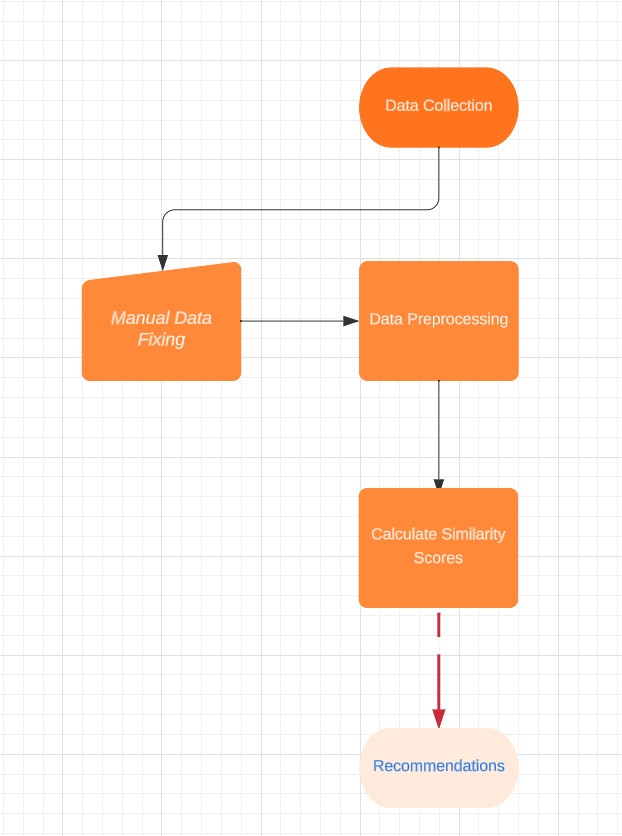

In [1]:
from IPython.display import Image

# Provide the path to your image file
image_path = 'flowchart.png'  # Replace with the actual image file path

# Display the image
Image(filename=image_path)


<center>
<h2>
References
</h2>
</center>

Bhattacharyya, M. (2022, December 7). Metrics of Recommender Systems. Medium. https://towardsdatascience.com/metrics-of-recommender-systems-cde64042127a#:~:text=Spearman%20Coefficient&text=It%20is%20a%20correlation%20of<br>

Javed, M. (2020, November 4). Using Cosine Similarity to Build a Movie Recommendation System. Medium. https://towardsdatascience.com/using-cosine-similarity-to-build-a-movie-recommendation-system-ae7f20842599<br>

Vatsal. (2021, November 3). Recommendation Systems Explained. Medium. https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed<br>

Wikipedia Contributors. (2019a, March 3). Cosine similarity. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Cosine_similarity<br>

Wikipedia Contributors. (2019b, September 7). Spearman’s rank correlation coefficient. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient<br>
‌

**AI Tools**
I used ChatGPT to:
- Fill in missing restaurant data - descriptions column
- Get Latex formatting for mathematical formulae
- Put comments and docstrings in functions
- Get simpler explanations on new concepts